# **Federated Learning with PeerReviewFlower and FedLS**

## Installing dependencies

First, we install the necessary packages:

In [ ]:
# Multiple ways to import prflwr whether it is installed
# as a Python module, in a Colab environment or if source
# code is in a parent directory for local development.
def import_prflwr():
    import os
    try: import prflwr; return
    except: pass
    if "setup.py" in os.listdir("../.."):
        os.chdir("../..")
        try: import prflwr
        except: pass
        finally: os.chdir("experiments/fedls")
        if prflwr: return
    try:
        import google.colab
        os.system(
            "pip install git+https://github.com/passerim/peer-review-flower.git"
        )
        import prflwr; return
    except: raise ModuleNotFoundError("No module named 'prflwr'")


import_prflwr()

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
import os
import random
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple, Union

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server import ServerConfig
from flwr.server.client_manager import ClientManager, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.simulation import start_simulation
from overrides import overrides
from torch.utils.data import DataLoader, Subset, random_split

from prflwr.peer_review import (
    PeerReviewNumPyClient,
    PeerReviewServer,
    ReviewIns,
    ReviewRes,
    TrainIns,
    TrainRes,
)
from prflwr.peer_review.strategy import (
    AggregateReviewException,
    AggregateTrainException,
    ConfigureReviewException,
    PeerReviewStrategy,
)
from prflwr.simulation import start_simulation
from prflwr.utils import non_iid_partitions

## Setup

Set useful constants, experiments settings and random seed.

In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # admissible values: "CIFAR10" or "CIFAR100"
NUM_ROUNDS = 30
NUM_CLIENTS = 100
LOCAL_EPOCHS = 5
BATCH_SIZE = 25
FRACTION_REVIEW = 0.1
FRACTION_TRAIN = 0.1
FRACTION_EVAL = 0  # Model performance will be evaluated in a centralized way
print(f"Training for {NUM_ROUNDS} rounds")

# Device to use for training and evaluation
DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")

Training for 30 rounds
Training on cpu


## Data loading

Let's now load the CIFAR-10 (or CIFAR-100) training and test set, partition them into `NUM_CLIENTS` smaller datasets (each split into training and validation set), and wrap everything in their own `DataLoader`. Test data will be used to evaluate the performance of the model in a centralized way.

In [ ]:
def load_datasets(
    num_clients: int,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

100%|██████████| 170498071/170498071 [00:01<00:00, 101371249.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model training/evaluation

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, optimizer, epochs=1, verbose=True):
    """Train the network on the training set."""
    net.train()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= batch + 1
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, train accuracy {epoch_acc}")
    return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the test set."""
    net.eval()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= batch + 1
    accuracy = correct / total
    return loss, accuracy

Let's check model's correctness, then print some info about the datasets and splits.

In [ ]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))

Model parameters: 45626
Client's trainset size: 450
Client's validation set size: 50
Server's testset size: 10000


## Build a custom Strategy implementing `PeerReviewStrategy`

We are now going to implement a new peer review federated learning strategy which requires a review round to perform line search on the size of the standard FedAvg update.

### Flower client

To implement the client, we create a subclass of `prflwr.peer_review.PeerReviewNumPyClient` and implement the four methods `get_parameters`, `train`, `review` and `evaluate`.

In [ ]:
class FedLSClient(PeerReviewNumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def train(self, parameters, config):
        current_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.cid}, round {current_round}] train, config: {config}")
        set_parameters(self.net, parameters)
        optimizer = torch.optim.Adam(self.net.parameters())
        train(self.net, self.trainloader, optimizer, local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def review(self, parameters, config):
        current_round = config["server_round"]
        max_evaluations = config["max_evaluations"]
        gamma = config["gamma"]
        eta = config["eta0"]
        print(f"[Client {self.cid}, round {current_round}] review, config: {config}")
        losses = []
        for i in range(max_evaluations):
            loss, num_examples, _ = self.evaluate(
                [eta * param for param in parameters], {}
            )
            losses.append(loss)
            eta = eta * gamma
        review_metrics = dict(enumerate(losses))
        return [], num_examples, review_metrics

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {}


def client_fn(cid) -> FedLSClient:
    net = Net(NUM_CLASSES).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FedLSClient(cid, net, trainloader, valloader)

### FedLS strategy

This is the implementation of the Federated Line Search (FedLS) strategy in PeerReviewFlower. The FedLS class extends the abstract class `prflwr.peer_review.strategy.PeerReviewStrategy` and makes use of a `flwr.server.strategy.FedAvg` object to reuse the FedAvg implementation of the methods which need no customization with respect to the FedAvg implementation. Alternatively it could be also implemented by extending the class `prflwr.peer_review.strategy.PeerReviewedFedAvg`.

In [ ]:
class FedLS(PeerReviewStrategy):
    def __init__(
        self,
        *,
        max_evaluations: int = 5,
        max_step_size: float = 1,
        min_step_size: float = 1e-5,
        step_size_decay: float = 0.1,
        fraction_review: float = 0.1,
        fraction_train: float = 0.1,
        fraction_evaluate: float = 0.1,
        min_review_clients: int = 2,
        min_train_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_review_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_train_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        train_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
    ) -> None:
        super(FedLS, self).__init__()

        # Strategy adapter fields
        self.max_evaluations = max_evaluations
        self.max_step_size = max_step_size
        self.min_step_size = min_step_size
        self.step_size_decay = step_size_decay

        # Strategy adapter fields
        self.fraction_review = fraction_review
        self.min_review_clients = min_review_clients
        self.on_review_config_fn = on_review_config_fn
        self.fedavg = FedAvg(
            fraction_fit=fraction_train,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_train_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_train_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=train_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

    def num_review_clients(self, num_available_clients: int):
        """Return the sample size and the required number of available
        clients."""
        num_clients = int(num_available_clients * self.fraction_review)
        return (
            max(num_clients, self.min_review_clients),
            self.fedavg.min_available_clients,
        )

    # Standard strategy
    @overrides
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        return self.fedavg.initialize_parameters(client_manager)

    @overrides
    def configure_evaluate(
        self, server_round: int, parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        return self.fedavg.configure_evaluate(server_round, parameters, client_manager)

    @overrides
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        return self.fedavg.aggregate_evaluate(server_round, results, failures)

    @overrides
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        return self.fedavg.evaluate(server_round, parameters)

    # Multiple reviews strategy
    @overrides
    def configure_train(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, TrainIns]]:
        print(f"Round: {server_round}, configure_train")
        return self.fedavg.configure_fit(server_round, parameters, client_manager)

    @overrides
    def aggregate_train(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, TrainRes]],
        failures: List[Union[Tuple[ClientProxy, TrainRes], BaseException]],
        parameters: Optional[Parameters],
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        print(f"Round: {server_round}, aggregate_train")
        parameters_aggregated, metrics_aggregated = self.fedavg.aggregate_fit(
            server_round, results, failures
        )
        current_weights = parameters_to_ndarrays(parameters)
        weights_aggregated = parameters_to_ndarrays(parameters_aggregated)
        gradient = [
            weights_aggregated[i] - current_weights[i]
            for i in range(len(weights_aggregated))
        ]
        gradient_params = ndarrays_to_parameters(gradient)
        return [(gradient_params, metrics_aggregated)]

    @overrides
    def configure_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[ClientProxy, ReviewIns]]:
        # Do not configure federated review if fraction_review is 0
        if self.fraction_review == 0.0:
            raise ConfigureReviewException

        # Parameters and config
        config = {}
        if self.on_review_config_fn is not None:
            # Custom review config function provided
            config = self.on_review_config_fn(server_round, review_round)

        # Prepare review instructions
        config.setdefault("server_round", server_round)
        config.setdefault("eta0", self.max_step_size)
        config.setdefault("gamma", self.step_size_decay)
        config.setdefault("max_evaluations", self.max_evaluations)
        review_ins = ReviewIns(parameters_aggregated[0], config)

        # Sample clients
        sample_size, min_num_clients = self.num_review_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        print(f"Round: {server_round}, review_round: {review_round}, configure_review")
        # Return client/config pairs
        return [(client, review_ins) for client in clients]

    @overrides
    def aggregate_review(
        self,
        server_round: int,
        review_round: int,
        results: List[Tuple[ClientProxy, ReviewRes]],
        failures: List[Union[Tuple[ClientProxy, ReviewRes], BaseException]],
        parameters: Parameters,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        print(f"Round: {server_round}, aggregate_review")
        if not results:
            raise AggregateReviewException

        # Do not aggregate if there are failures and failures are not accepted
        if not self.fedavg.accept_failures and failures:
            raise AggregateReviewException

        # Aggregate results
        losses = []
        for i in range(self.max_evaluations):
            aggregated_loss = weighted_loss_avg(
                [
                    (review_res.num_examples, review_res.metrics[i])
                    for _, review_res in results
                ]
            )
            losses.append(aggregated_loss)
        metrics_aggregated[0].setdefault(
            "step_size",
            self.max_step_size * (self.step_size_decay ** np.argmin(losses)),
        )
        # Return parameters update and step size
        return list(zip(parameters_aggregated, metrics_aggregated))

    @overrides
    def aggregate_after_review(
        self,
        server_round: int,
        parameters: Optional[Parameters],
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> Optional[Parameters]:
        print(f"Round: {server_round}, aggregate_after_review")
        weights = parameters_to_ndarrays(parameters)
        gradient = parameters_to_ndarrays(parameters_aggregated[0])
        
        # Compute update
        step_size = max(self.min_step_size, metrics_aggregated[0]["step_size"])
        for j, tensor in enumerate(gradient):
            weights[j] += step_size * gradient[j]
        print(f"Round {server_round}: lr {step_size}")

        # Return new global parameters
        parameters_prime = ndarrays_to_parameters(weights)
        return parameters_prime

    @overrides
    def stop_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> bool:
        print(f"Round: {server_round}, review_round: {review_round}, stop_review")
        return True

## Running federated learning

Let's run a federated learning experiment with a large number of clients. We have 100 partitions, each holding 450 training and 50 validation examples. We configure the clients to perform 5 local training epochs. The federated learning simulation is started by the function `start_simulation`, in this case we will use the concurrent simulation implemented in PeerReviewFlower. The `start_simulation` function accepts a number of arguments:
* `client_fn` is used to create `FedLSClient` instances,
* the number of clients to simulate is specified by `num_clients`,
* the number of rounds `num_rounds` is encapsulated in a `flwr.server.ServerConfig`,
* `strategy` is used to specify the custom strategy we configured above.

The FedLS strategy runs a review round in which line search is performed by the clients on the standard FedAvg update computed in the train round. Each individual client result of the line search is aggregated at the end of the review round and the global model's parameters are updated using the step size which provided the maximum reduction of the loss function. A maximum number of line search steps `FedLS.max_evaluations=5` is performed by each client participating in the review round.

In [ ]:
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net(NUM_CLASSES).to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}


def train_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config


def review_config(server_round: int, review_round: int):
    return {"server_round": server_round, "review_round": review_round}


initial_parameters = fl.common.ndarrays_to_parameters(get_parameters(Net(NUM_CLASSES)))

strategy = FedLS(
    fraction_review=FRACTION_REVIEW,
    fraction_train=FRACTION_TRAIN,
    fraction_evaluate=FRACTION_EVAL,
    min_review_clients=int(FRACTION_REVIEW * NUM_CLIENTS),
    min_train_clients=int(NUM_CLIENTS * FRACTION_TRAIN),
    min_evaluate_clients=int(NUM_CLIENTS * FRACTION_EVAL),
    min_available_clients=NUM_CLIENTS,
    initial_parameters=initial_parameters,  # Pass initial paramenters
    on_train_config_fn=train_config,        # Pass the train_config function
    on_review_config_fn=review_config,      # Pass the review_config function
    evaluate_fn=evaluate,                   # Pass the evaluation function
)

client_manager = SimpleClientManager()
server = PeerReviewServer(client_manager, strategy)

history = start_simulation(
    server=server,
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

WARNING flower 2023-05-25 22:24:40,334 | app.py:177 | Both server and strategy were provided, ignoring strategy
INFO flower 2023-05-25 22:24:40,340 | app.py:69 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flower 2023-05-25 22:24:40,478 | server.py:126 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2023-05-25 22:24:40,485 | server.py:409 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2023-05-25 22:24:40,492 | server.py:129 | Evaluating initial parameters
INFO:flower:Evaluating initial parameters
INFO flower 2023-05-25 22:24:48,667 | server.py:132 | initial parameters (loss, other metrics): 2.303888045549393, {'accuracy': 0.1018}
INFO:flower:initial parameters (loss, other metrics): 2.303888045549393, {'accuracy': 0.1018}
INFO flower 2023

Server-side evaluation loss 2.303888045549393 / accuracy 0.1018
Round: 1, configure_train
[Client 6, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
[Client 34, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
[Client 11, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
[Client 98, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
[Client 52, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
[Client 13, round 1] train, config: {'server_round': 1, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 2.2933674918280706, train accuracy 0.14
Epoch 1: train loss 2.298355142275492, train accuracy 0.13111111111111112
Epoch 1: train loss 2.2982745038138495, train accuracy 0.1111111111111111
Epoch 1: train loss 2.3011081086264715, train accuracy 0.1111111111111111
Epoch 1: train loss 2.2990157869127064, train accuracy 0.1288888888888889
Epo

DEBUG flower 2023-05-25 22:25:04,613 | server.py:279 | train_round 1 received 10 results and 0 failures
DEBUG:flower:train_round 1 received 10 results and 0 failures
WARNING flower 2023-05-25 22:25:04,633 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flower 2023-05-25 22:25:04,643 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.0891452034314475, train accuracy 0.20666666666666667
Epoch 5: train loss 2.0756314198176065, train accuracy 0.21555555555555556
Epoch 5: train loss 2.065969612863329, train accuracy 0.22666666666666666
Round: 1, aggregate_train
Round: 1, review_round: 1, configure_review
[Client 42, round 1] review, config: {'server_round': 1, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43, round 1] review, config: {'server_round': 1, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43] evaluate, config: {}
[Client 6, round 1] review, config: {'server_round': 1, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 6] evaluate, config: {}
[Client 42] evaluate, config: {}
[Client 20, round 1] review, config: {'server_round': 1, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 20] evaluate, config: {}
[Client 17, round 1]

DEBUG flower 2023-05-25 22:25:06,320 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 1, aggregate_review
Round: 1, review_round: 1, stop_review
Round: 1, aggregate_after_review
Round 1: lr 1.0


INFO flower 2023-05-25 22:25:09,370 | server.py:190 | fit progress: (
	server_round: 1,
	centralized_loss: 2.0969753941893576,
	metrics: {'accuracy': 0.235},
	time_elapsed 20.683186292648315
)
INFO:flower:fit progress: (
	server_round: 1,
	centralized_loss: 2.0969753941893576,
	metrics: {'accuracy': 0.235},
	time_elapsed 20.683186292648315
)
INFO flower 2023-05-25 22:25:09,372 | server.py:163 | evaluate_round 1: no clients selected, cancel
INFO:flower:evaluate_round 1: no clients selected, cancel
DEBUG flower 2023-05-25 22:25:09,378 | server.py:264 | train_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 2: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.0969753941893576 / accuracy 0.235
Round: 2, configure_train
[Client 99, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 11, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 76, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 48, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 8, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 0, round 2] train, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 2.1042723258336387, train accuracy 0.2088888888888889
Epoch 1: train loss 2.1373739507463245, train accuracy 0.21333333333333335
Epoch 1: train loss 2.048101822535197, train accuracy 0.24444444444444444
Epoch 1: train loss 2.0730668107668557, train accuracy 0.2511111111111111
Epoch 1: train loss 2.129578020837572, train accuracy 0.1933333

DEBUG flower 2023-05-25 22:25:24,933 | server.py:279 | train_round 2 received 10 results and 0 failures
DEBUG:flower:train_round 2 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:25:24,959 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.044789883825514, train accuracy 0.23333333333333334
Epoch 5: train loss 2.074596087137858, train accuracy 0.23333333333333334
Epoch 5: train loss 2.0563507874806723, train accuracy 0.2222222222222222
Epoch 5: train loss 2.0133674674563937, train accuracy 0.2733333333333333
Round: 2, aggregate_train
Round: 2, review_round: 1, configure_review
[Client 5, round 2] review, config: {'server_round': 2, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 5] evaluate, config: {}
[Client 11, round 2] review, config: {'server_round': 2, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 11] evaluate, config: {}
[Client 18, round 2] review, config: {'server_round': 2, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 18] evaluate, config: {}
[Client 85, round 2] review, config: {'server_round': 2, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 

DEBUG flower 2023-05-25 22:25:26,305 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 2, aggregate_review
Round: 2, review_round: 1, stop_review
Round: 2, aggregate_after_review
Round 2: lr 1.0


INFO flower 2023-05-25 22:25:29,997 | server.py:190 | fit progress: (
	server_round: 2,
	centralized_loss: 1.9810075134038925,
	metrics: {'accuracy': 0.2721},
	time_elapsed 41.310683250427246
)
INFO:flower:fit progress: (
	server_round: 2,
	centralized_loss: 1.9810075134038925,
	metrics: {'accuracy': 0.2721},
	time_elapsed 41.310683250427246
)
INFO flower 2023-05-25 22:25:30,000 | server.py:163 | evaluate_round 2: no clients selected, cancel
INFO:flower:evaluate_round 2: no clients selected, cancel
DEBUG flower 2023-05-25 22:25:30,006 | server.py:264 | train_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 3: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.9810075134038925 / accuracy 0.2721
Round: 3, configure_train
[Client 33, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 60, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 4, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 98, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 43, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 39, round 3] train, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 2.1019043458832636, train accuracy 0.2111111111111111
Epoch 1: train loss 1.9856156640582614, train accuracy 0.23333333333333334
Epoch 1: train loss 2.057721628083123, train accuracy 0.24
Epoch 1: train loss 2.0618246462610035, train accuracy 0.20222222222222222
Epoch 1: train loss 2.0908977720472546, train accuracy 0.21555555555555556


DEBUG flower 2023-05-25 22:25:45,688 | server.py:279 | train_round 3 received 10 results and 0 failures
DEBUG:flower:train_round 3 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:25:45,711 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.941934929953681, train accuracy 0.25555555555555554
Epoch 5: train loss 1.9300182395511203, train accuracy 0.28
Epoch 5: train loss 1.9132215248213873, train accuracy 0.27111111111111114
Round: 3, aggregate_train
Round: 3, review_round: 1, configure_review
[Client 81, round 3] review, config: {'server_round': 3, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 67, round 3] review, config: {'server_round': 3, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 67] evaluate, config: {}
[Client 81] evaluate, config: {}
[Client 72, round 3] review, config: {'server_round': 3, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 40, round 3] review, config: {'server_round': 3, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 72] evaluate, config: {}
[Client 40] evaluate, config: {}
[Client 50, round 3] review, conf

DEBUG flower 2023-05-25 22:25:47,296 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 3, aggregate_review
Round: 3, review_round: 1, stop_review
Round: 3, aggregate_after_review
Round 3: lr 0.0010000000000000002


INFO flower 2023-05-25 22:25:50,321 | server.py:190 | fit progress: (
	server_round: 3,
	centralized_loss: 1.980923497080803,
	metrics: {'accuracy': 0.2722},
	time_elapsed 61.634819746017456
)
INFO:flower:fit progress: (
	server_round: 3,
	centralized_loss: 1.980923497080803,
	metrics: {'accuracy': 0.2722},
	time_elapsed 61.634819746017456
)
INFO flower 2023-05-25 22:25:50,325 | server.py:163 | evaluate_round 3: no clients selected, cancel
INFO:flower:evaluate_round 3: no clients selected, cancel
DEBUG flower 2023-05-25 22:25:50,329 | server.py:264 | train_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 4: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.980923497080803 / accuracy 0.2722
Round: 4, configure_train
[Client 87, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 68, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 81, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 85, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 76, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 62, round 4] train, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 2.0227832992871604, train accuracy 0.24222222222222223
Epoch 1: train loss 2.012786520851983, train accuracy 0.23333333333333334
Epoch 1: train loss 2.0870360732078552, train accuracy 0.23333333333333334
Epoch 1: train loss 2.0326090190145703, train accuracy 0.24444444444444444
Epoch 1: train loss 2.1039156913757324, train accuracy 0.21

DEBUG flower 2023-05-25 22:26:05,655 | server.py:279 | train_round 4 received 10 results and 0 failures
DEBUG:flower:train_round 4 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:26:05,689 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.919045819176568, train accuracy 0.29777777777777775Epoch 5: train loss 1.9423965877956815, train accuracy 0.2911111111111111

Epoch 5: train loss 1.9067524075508118, train accuracy 0.28444444444444444
Epoch 5: train loss 1.9441307584444683, train accuracy 0.2777777777777778
Round: 4, aggregate_train
Round: 4, review_round: 1, configure_review
[Client 4, round 4] review, config: {'server_round': 4, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 4] evaluate, config: {}
[Client 96, round 4] review, config: {'server_round': 4, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 96] evaluate, config: {}
[Client 82, round 4] review, config: {'server_round': 4, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 82] evaluate, config: {}
[Client 4] evaluate, config: {}
[Client 96] evaluate, config: {}
[Client 23, round 4] review, config: {'server_round': 

DEBUG flower 2023-05-25 22:26:07,142 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 33] evaluate, config: {}
[Client 21] evaluate, config: {}
Round: 4, aggregate_review
Round: 4, review_round: 1, stop_review
Round: 4, aggregate_after_review
Round 4: lr 1.0


INFO flower 2023-05-25 22:26:13,113 | server.py:190 | fit progress: (
	server_round: 4,
	centralized_loss: 1.897779335975647,
	metrics: {'accuracy': 0.2941},
	time_elapsed 84.42671990394592
)
INFO:flower:fit progress: (
	server_round: 4,
	centralized_loss: 1.897779335975647,
	metrics: {'accuracy': 0.2941},
	time_elapsed 84.42671990394592
)
INFO flower 2023-05-25 22:26:13,119 | server.py:163 | evaluate_round 4: no clients selected, cancel
INFO:flower:evaluate_round 4: no clients selected, cancel
DEBUG flower 2023-05-25 22:26:13,122 | server.py:264 | train_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 5: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.897779335975647 / accuracy 0.2941
Round: 5, configure_train
[Client 42, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 43, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 70, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 50, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 9, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 92, round 5] train, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.9284923407766554, train accuracy 0.27111111111111114
Epoch 1: train loss 2.0220991439289517, train accuracy 0.2511111111111111
Epoch 1: train loss 2.0153733028305902, train accuracy 0.25333333333333335
Epoch 1: train loss 1.9613923960261874, train accuracy 0.25555555555555554
Epoch 1: train loss 2.0224163797166614, train accuracy 0.228

DEBUG flower 2023-05-25 22:26:29,701 | server.py:279 | train_round 5 received 10 results and 0 failures
DEBUG:flower:train_round 5 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:26:29,734 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.805441975593567, train accuracy 0.31777777777777777
Epoch 5: train loss 1.8457493782043457, train accuracy 0.3288888888888889
Epoch 5: train loss 1.8825246161884732, train accuracy 0.31333333333333335
Epoch 5: train loss 1.8284027245309618, train accuracy 0.3088888888888889
Round: 5, aggregate_train
Round: 5, review_round: 1, configure_review
[Client 43, round 5] review, config: {'server_round': 5, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 2, round 5] review, config: {'server_round': 5, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43] evaluate, config: {}[Client 2] evaluate, config: {}
[Client 24, round 5] review, config: {'server_round': 5, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

[Client 24] evaluate, config: {}
[Client 75, round 5] review, config: {'server_round': 5, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations':

DEBUG flower 2023-05-25 22:26:31,444 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 5, aggregate_review
Round: 5, review_round: 1, stop_review
Round: 5, aggregate_after_review
Round 5: lr 1.0


INFO flower 2023-05-25 22:26:35,641 | server.py:190 | fit progress: (
	server_round: 5,
	centralized_loss: 1.8352089184522629,
	metrics: {'accuracy': 0.321},
	time_elapsed 106.95505499839783
)
INFO:flower:fit progress: (
	server_round: 5,
	centralized_loss: 1.8352089184522629,
	metrics: {'accuracy': 0.321},
	time_elapsed 106.95505499839783
)
INFO flower 2023-05-25 22:26:35,644 | server.py:163 | evaluate_round 5: no clients selected, cancel
INFO:flower:evaluate_round 5: no clients selected, cancel
DEBUG flower 2023-05-25 22:26:35,648 | server.py:264 | train_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 6: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.8352089184522629 / accuracy 0.321
Round: 6, configure_train
[Client 51, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 68, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 92, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 64, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 7, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 81, round 6] train, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.886481589741177, train accuracy 0.27555555555555555
Epoch 1: train loss 1.9601815872722201, train accuracy 0.2733333333333333
Epoch 1: train loss 1.9632010526127286, train accuracy 0.2777777777777778
Epoch 1: train loss 1.9280035230848525, train accuracy 0.2733333333333333
Epoch 1: train loss 1.9886296855078802, train accuracy 0.273333

DEBUG flower 2023-05-25 22:26:52,016 | server.py:279 | train_round 6 received 10 results and 0 failures
DEBUG:flower:train_round 6 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:26:52,045 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.7678716712527804, train accuracy 0.3511111111111111
Epoch 5: train loss 1.8614083329836528, train accuracy 0.33555555555555555
Epoch 5: train loss 1.8007062209977045, train accuracy 0.31555555555555553
Epoch 5: train loss 1.8238992757267423, train accuracy 0.3288888888888889
Round: 6, aggregate_train
Round: 6, review_round: 1, configure_review
[Client 92, round 6] review, config: {'server_round': 6, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 29, round 6] review, config: {'server_round': 6, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 92] evaluate, config: {}
[Client 29] evaluate, config: {}
[Client 69, round 6] review, config: {'server_round': 6, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 69] evaluate, config: {}[Client 61, round 6] review, config: {'server_round': 6, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations

DEBUG flower 2023-05-25 22:26:53,837 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 96] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 56] evaluate, config: {}
[Client 48] evaluate, config: {}
Round: 6, aggregate_review
Round: 6, review_round: 1, stop_review
Round: 6, aggregate_after_review
Round 6: lr 0.1


INFO flower 2023-05-25 22:26:56,968 | server.py:190 | fit progress: (
	server_round: 6,
	centralized_loss: 1.8288317981362343,
	metrics: {'accuracy': 0.3243},
	time_elapsed 128.28146624565125
)
INFO:flower:fit progress: (
	server_round: 6,
	centralized_loss: 1.8288317981362343,
	metrics: {'accuracy': 0.3243},
	time_elapsed 128.28146624565125
)
INFO flower 2023-05-25 22:26:56,971 | server.py:163 | evaluate_round 6: no clients selected, cancel
INFO:flower:evaluate_round 6: no clients selected, cancel
DEBUG flower 2023-05-25 22:26:56,974 | server.py:264 | train_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 7: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.8288317981362343 / accuracy 0.3243
Round: 7, configure_train
[Client 59, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 5, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 17, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 1, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 58, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 24, round 7] train, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.9239330622884963, train accuracy 0.2822222222222222
Epoch 1: train loss 1.8947134481536017, train accuracy 0.28444444444444444
Epoch 1: train loss 1.877568503220876, train accuracy 0.28888888888888886
Epoch 1: train loss 1.9392264948950872, train accuracy 0.24222222222222223
Epoch 1: train loss 2.0003279646237693, train accuracy 0.2355

DEBUG flower 2023-05-25 22:27:13,001 | server.py:279 | train_round 7 received 10 results and 0 failures
DEBUG:flower:train_round 7 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:27:13,055 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.8933450910780165, train accuracy 0.31333333333333335
Epoch 5: train loss 1.8108019762569003, train accuracy 0.3422222222222222
Epoch 5: train loss 1.8078423804706998, train accuracy 0.34444444444444444
Epoch 5: train loss 1.8210949963993497, train accuracy 0.3022222222222222
Round: 7, aggregate_train
Round: 7, review_round: 1, configure_review
[Client 34, round 7] review, config: {'server_round': 7, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 55, round 7] review, config: {'server_round': 7, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 34] evaluate, config: {}

[Client 81, round 7] review, config: {'server_round': 7, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 81] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 53, round 7] review, config: {'server_round': 7, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluation

DEBUG flower 2023-05-25 22:27:14,860 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 65] evaluate, config: {}
[Client 79] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 45] evaluate, config: {}
Round: 7, aggregate_review
Round: 7, review_round: 1, stop_review
Round: 7, aggregate_after_review
Round 7: lr 1.0


INFO flower 2023-05-25 22:27:17,997 | server.py:190 | fit progress: (
	server_round: 7,
	centralized_loss: 1.7790266999602318,
	metrics: {'accuracy': 0.3469},
	time_elapsed 149.31064891815186
)
INFO:flower:fit progress: (
	server_round: 7,
	centralized_loss: 1.7790266999602318,
	metrics: {'accuracy': 0.3469},
	time_elapsed 149.31064891815186
)
INFO flower 2023-05-25 22:27:18,001 | server.py:163 | evaluate_round 7: no clients selected, cancel
INFO:flower:evaluate_round 7: no clients selected, cancel
DEBUG flower 2023-05-25 22:27:18,004 | server.py:264 | train_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 8: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7790266999602318 / accuracy 0.3469
Round: 8, configure_train
[Client 90, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 11, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 10, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 55, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 1, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 68, round 8] train, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.903840614689721, train accuracy 0.29555555555555557
Epoch 1: train loss 1.9455572300487094, train accuracy 0.2911111111111111
Epoch 1: train loss 1.9394123554229736, train accuracy 0.28
Epoch 1: train loss 1.9032928480042353, train accuracy 0.3288888888888889
Epoch 1: train loss 1.8395234081480238, train accuracy 0.2866666666666667
Ep

DEBUG flower 2023-05-25 22:27:34,349 | server.py:279 | train_round 8 received 10 results and 0 failures
DEBUG:flower:train_round 8 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:27:34,375 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.7592545019255743, train accuracy 0.33111111111111113
Epoch 5: train loss 1.754154258304172, train accuracy 0.34
Epoch 5: train loss 1.7912589179144964, train accuracy 0.3244444444444444
Epoch 5: train loss 1.7468596167034574, train accuracy 0.3488888888888889
Round: 8, aggregate_train
Round: 8, review_round: 1, configure_review
[Client 81, round 8] review, config: {'server_round': 8, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 81] evaluate, config: {}
[Client 51, round 8] review, config: {'server_round': 8, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 3, round 8] review, config: {'server_round': 8, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 51] evaluate, config: {}[Client 3] evaluate, config: {}

[Client 41, round 8] review, config: {'server_round': 8, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': T

DEBUG flower 2023-05-25 22:27:36,104 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 8, aggregate_review
Round: 8, review_round: 1, stop_review
Round: 8, aggregate_after_review
Round 8: lr 1.0


INFO flower 2023-05-25 22:27:40,301 | server.py:190 | fit progress: (
	server_round: 8,
	centralized_loss: 1.7427193772792817,
	metrics: {'accuracy': 0.36},
	time_elapsed 171.61453771591187
)
INFO:flower:fit progress: (
	server_round: 8,
	centralized_loss: 1.7427193772792817,
	metrics: {'accuracy': 0.36},
	time_elapsed 171.61453771591187
)
INFO flower 2023-05-25 22:27:40,304 | server.py:163 | evaluate_round 8: no clients selected, cancel
INFO:flower:evaluate_round 8: no clients selected, cancel
DEBUG flower 2023-05-25 22:27:40,306 | server.py:264 | train_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 9: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7427193772792817 / accuracy 0.36
Round: 9, configure_train
[Client 53, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 44, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 3, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 81, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 20, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 8, round 9] train, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.9254996909035578, train accuracy 0.2911111111111111
Epoch 1: train loss 1.84893047147327, train accuracy 0.32222222222222224
Epoch 1: train loss 1.8712394303745694, train accuracy 0.33555555555555555
Epoch 1: train loss 1.8018921282556322, train accuracy 0.29333333333333333
Epoch 1: train loss 1.8529678848054674, train accuracy 0.3311111

DEBUG flower 2023-05-25 22:27:56,328 | server.py:279 | train_round 9 received 10 results and 0 failures
DEBUG:flower:train_round 9 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:27:56,367 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.7260583970281813, train accuracy 0.3488888888888889
Epoch 5: train loss 1.6617895232306585, train accuracy 0.39111111111111113
Epoch 5: train loss 1.7955871356858149, train accuracy 0.33555555555555555
Epoch 5: train loss 1.6316091352038913, train accuracy 0.38222222222222224
Round: 9, aggregate_train
Round: 9, review_round: 1, configure_review
[Client 85, round 9] review, config: {'server_round': 9, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 85] evaluate, config: {}
[Client 30, round 9] review, config: {'server_round': 9, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 30] evaluate, config: {}
[Client 95, round 9] review, config: {'server_round': 9, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 95] evaluate, config: {}[Client 10, round 9] review, config: {'server_round': 9, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluation

DEBUG flower 2023-05-25 22:27:58,013 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 66] evaluate, config: {}
Round: 9, aggregate_review
Round: 9, review_round: 1, stop_review
Round: 9, aggregate_after_review
Round 9: lr 1.0


INFO flower 2023-05-25 22:28:01,184 | server.py:190 | fit progress: (
	server_round: 9,
	centralized_loss: 1.6946420612931252,
	metrics: {'accuracy': 0.3798},
	time_elapsed 192.49711418151855
)
INFO:flower:fit progress: (
	server_round: 9,
	centralized_loss: 1.6946420612931252,
	metrics: {'accuracy': 0.3798},
	time_elapsed 192.49711418151855
)
INFO flower 2023-05-25 22:28:01,186 | server.py:163 | evaluate_round 9: no clients selected, cancel
INFO:flower:evaluate_round 9: no clients selected, cancel
DEBUG flower 2023-05-25 22:28:01,192 | server.py:264 | train_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 10: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6946420612931252 / accuracy 0.3798
Round: 10, configure_train
[Client 39, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 18, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 83, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 98, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 37, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 99, round 10] train, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.8194818960295782, train accuracy 0.3288888888888889
Epoch 1: train loss 1.7432778278986614, train accuracy 0.3622222222222222
Epoch 1: train loss 1.8858914242850409, train accuracy 0.30666666666666664
Epoch 1: train loss 1.7328091859817505, train accuracy 0.3422222222222222
Epoch 1: train loss 1.7366450826327007, train a

DEBUG flower 2023-05-25 22:28:17,907 | server.py:279 | train_round 10 received 10 results and 0 failures
DEBUG:flower:train_round 10 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:28:17,950 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Round: 10, aggregate_train
Round: 10, review_round: 1, configure_review
[Client 43, round 10] review, config: {'server_round': 10, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43] evaluate, config: {}
[Client 66, round 10] review, config: {'server_round': 10, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 66] evaluate, config: {}
[Client 15, round 10] review, config: {'server_round': 10, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 15] evaluate, config: {}
[Client 80, round 10] review, config: {'server_round': 10, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 80] evaluate, config: {}
[Client 21, round 10] review, config: {'server_round': 10, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 21] evaluate, config: {}
[Client 75, round 10] review, config: {'server_round': 10,

DEBUG flower 2023-05-25 22:28:19,526 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 10, aggregate_review
Round: 10, review_round: 1, stop_review
Round: 10, aggregate_after_review
Round 10: lr 0.00010000000000000002


INFO flower 2023-05-25 22:28:23,053 | server.py:190 | fit progress: (
	server_round: 10,
	centralized_loss: 1.6946381351351738,
	metrics: {'accuracy': 0.3798},
	time_elapsed 214.36666679382324
)
INFO:flower:fit progress: (
	server_round: 10,
	centralized_loss: 1.6946381351351738,
	metrics: {'accuracy': 0.3798},
	time_elapsed 214.36666679382324
)
INFO flower 2023-05-25 22:28:23,060 | server.py:163 | evaluate_round 10: no clients selected, cancel
INFO:flower:evaluate_round 10: no clients selected, cancel
DEBUG flower 2023-05-25 22:28:23,064 | server.py:264 | train_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 11: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6946381351351738 / accuracy 0.3798
Round: 11, configure_train
[Client 17, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 58, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 85, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 2, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 57, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 44, round 11] train, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.8118811713324652, train accuracy 0.3466666666666667
Epoch 1: train loss 1.814436051580641, train accuracy 0.33555555555555555
Epoch 1: train loss 1.8113257951206632, train accuracy 0.32
Epoch 1: train loss 1.785971740881602, train accuracy 0.3488888888888889
Epoch 1: train loss 1.8272477851973639, train accuracy 0.3244444

DEBUG flower 2023-05-25 22:28:39,484 | server.py:279 | train_round 11 received 10 results and 0 failures
DEBUG:flower:train_round 11 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:28:39,516 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.6398403710789151, train accuracy 0.4066666666666667
Epoch 5: train loss 1.7440846893522475, train accuracy 0.36444444444444446
Round: 11, aggregate_train
Round: 11, review_round: 1, configure_review
[Client 54, round 11] review, config: {'server_round': 11, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 54] evaluate, config: {}
[Client 99, round 11] review, config: {'server_round': 11, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 99] evaluate, config: {}[Client 3, round 11] review, config: {'server_round': 11, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

[Client 66, round 11] review, config: {'server_round': 11, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 3] evaluate, config: {}
[Client 66] evaluate, config: {}
[Client 20, round 11] review, config: {'server_round': 11, 'review_round': 1, 'eta0':

DEBUG flower 2023-05-25 22:28:41,314 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 11, aggregate_review
Round: 11, review_round: 1, stop_review
Round: 11, aggregate_after_review
Round 11: lr 1.0


INFO flower 2023-05-25 22:28:44,767 | server.py:190 | fit progress: (
	server_round: 11,
	centralized_loss: 1.6614713579416276,
	metrics: {'accuracy': 0.3953},
	time_elapsed 236.08035731315613
)
INFO:flower:fit progress: (
	server_round: 11,
	centralized_loss: 1.6614713579416276,
	metrics: {'accuracy': 0.3953},
	time_elapsed 236.08035731315613
)
INFO flower 2023-05-25 22:28:44,770 | server.py:163 | evaluate_round 11: no clients selected, cancel
INFO:flower:evaluate_round 11: no clients selected, cancel
DEBUG flower 2023-05-25 22:28:44,773 | server.py:264 | train_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 12: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6614713579416276 / accuracy 0.3953
Round: 12, configure_train
[Client 64, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 13, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 92, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}[Client 69, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}

[Client 47, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}[Client 28, round 12] train, config: {'server_round': 12, 'local_epochs': 5, 'review': False}

Epoch 1: train loss 1.7119177314970229, train accuracy 0.37333333333333335Epoch 1: train loss 1.8208387030495539, train accuracy 0.34444444444444444
Epoch 1: train loss 1.7989225917392306, train accuracy 0.32222222222222224

Epoch 1: train loss 1.7480870220396254, train accuracy 0.3466666666666667
Epoch 1: train loss 1.7647427717844646, train

DEBUG flower 2023-05-25 22:29:01,206 | server.py:279 | train_round 12 received 10 results and 0 failures
DEBUG:flower:train_round 12 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:29:01,238 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.6459565162658691, train accuracy 0.4022222222222222
Epoch 5: train loss 1.6183505985471938, train accuracy 0.37555555555555553
Epoch 5: train loss 1.6216751999325223, train accuracy 0.3711111111111111
Epoch 5: train loss 1.670233474837409, train accuracy 0.4066666666666667
Round: 12, aggregate_train
Round: 12, review_round: 1, configure_review
[Client 64, round 12] review, config: {'server_round': 12, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 64] evaluate, config: {}
[Client 31, round 12] review, config: {'server_round': 12, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 31] evaluate, config: {}[Client 33, round 12] review, config: {'server_round': 12, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 26, round 12] review, config: {'server_round': 12, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Cl

DEBUG flower 2023-05-25 22:29:03,080 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 12, aggregate_review
Round: 12, review_round: 1, stop_review
Round: 12, aggregate_after_review
Round 12: lr 1.0


INFO flower 2023-05-25 22:29:06,312 | server.py:190 | fit progress: (
	server_round: 12,
	centralized_loss: 1.6299061009287834,
	metrics: {'accuracy': 0.4068},
	time_elapsed 257.62571811676025
)
INFO:flower:fit progress: (
	server_round: 12,
	centralized_loss: 1.6299061009287834,
	metrics: {'accuracy': 0.4068},
	time_elapsed 257.62571811676025
)
INFO flower 2023-05-25 22:29:06,317 | server.py:163 | evaluate_round 12: no clients selected, cancel
INFO:flower:evaluate_round 12: no clients selected, cancel
DEBUG flower 2023-05-25 22:29:06,320 | server.py:264 | train_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 13: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6299061009287834 / accuracy 0.4068
Round: 13, configure_train
[Client 2, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 24, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 34, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 29, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 10, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 72, round 13] train, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.8024224638938904, train accuracy 0.3511111111111111
Epoch 1: train loss 1.6916755106714036, train accuracy 0.3622222222222222
Epoch 1: train loss 1.7814335227012634, train accuracy 0.36
Epoch 1: train loss 1.8077211247550116, train accuracy 0.32666666666666666
Epoch 1: train loss 1.8094710641437106, train accuracy 0.35333

DEBUG flower 2023-05-25 22:29:22,951 | server.py:279 | train_round 13 received 10 results and 0 failures
DEBUG:flower:train_round 13 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:29:22,985 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5552658571137323, train accuracy 0.44222222222222224
Round: 13, aggregate_train
Round: 13, review_round: 1, configure_review
[Client 68, round 13] review, config: {'server_round': 13, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 68] evaluate, config: {}
[Client 17, round 13] review, config: {'server_round': 13, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 61, round 13] review, config: {'server_round': 13, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 17] evaluate, config: {}[Client 61] evaluate, config: {}

[Client 63, round 13] review, config: {'server_round': 13, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 63] evaluate, config: {}
[Client 50, round 13] review, config: {'server_round': 13, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 50] eval

DEBUG flower 2023-05-25 22:29:24,439 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 99] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 32] evaluate, config: {}[Client 91] evaluate, config: {}

Round: 13, aggregate_review
Round: 13, review_round: 1, stop_review
Round: 13, aggregate_after_review
Round 13: lr 0.0010000000000000002


INFO flower 2023-05-25 22:29:28,311 | server.py:190 | fit progress: (
	server_round: 13,
	centralized_loss: 1.6298681837320328,
	metrics: {'accuracy': 0.407},
	time_elapsed 279.62446904182434
)
INFO:flower:fit progress: (
	server_round: 13,
	centralized_loss: 1.6298681837320328,
	metrics: {'accuracy': 0.407},
	time_elapsed 279.62446904182434
)
INFO flower 2023-05-25 22:29:28,319 | server.py:163 | evaluate_round 13: no clients selected, cancel
INFO:flower:evaluate_round 13: no clients selected, cancel
DEBUG flower 2023-05-25 22:29:28,323 | server.py:264 | train_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 14: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6298681837320328 / accuracy 0.407
Round: 14, configure_train
[Client 73, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 62, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 43, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 50, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 28, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}[Client 64, round 14] train, config: {'server_round': 14, 'local_epochs': 5, 'review': False}

Epoch 1: train loss 1.7750699586338468, train accuracy 0.3422222222222222
Epoch 1: train loss 1.7951867646641202, train accuracy 0.35555555555555557
Epoch 1: train loss 1.802673531903161, train accuracy 0.30666666666666664
Epoch 1: train loss 1.7827356722619798, train accuracy 0.3288888888888889
Epoch 1: train loss 1.7646302448378668, train ac

DEBUG flower 2023-05-25 22:29:44,734 | server.py:279 | train_round 14 received 10 results and 0 failures
DEBUG:flower:train_round 14 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:29:44,768 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.680455505847931, train accuracy 0.38222222222222224
Epoch 5: train loss 1.5505246056450739, train accuracy 0.4222222222222222
Round: 14, aggregate_train
Round: 14, review_round: 1, configure_review
[Client 76, round 14] review, config: {'server_round': 14, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 76] evaluate, config: {}
[Client 77, round 14] review, config: {'server_round': 14, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 77] evaluate, config: {}
[Client 63, round 14] review, config: {'server_round': 14, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 63] evaluate, config: {}
[Client 89, round 14] review, config: {'server_round': 14, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 89] evaluate, config: {}
[Client 74, round 14] review, config: {'server_round': 14, 'review_round': 1, 'eta0'

DEBUG flower 2023-05-25 22:29:46,491 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 14, aggregate_review
Round: 14, review_round: 1, stop_review
Round: 14, aggregate_after_review
Round 14: lr 1.0


INFO flower 2023-05-25 22:29:49,624 | server.py:190 | fit progress: (
	server_round: 14,
	centralized_loss: 1.612213957607746,
	metrics: {'accuracy': 0.4115},
	time_elapsed 300.93803238868713
)
INFO:flower:fit progress: (
	server_round: 14,
	centralized_loss: 1.612213957607746,
	metrics: {'accuracy': 0.4115},
	time_elapsed 300.93803238868713
)
INFO flower 2023-05-25 22:29:49,626 | server.py:163 | evaluate_round 14: no clients selected, cancel
INFO:flower:evaluate_round 14: no clients selected, cancel
DEBUG flower 2023-05-25 22:29:49,631 | server.py:264 | train_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 15: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.612213957607746 / accuracy 0.4115
Round: 15, configure_train
[Client 58, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 46, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 85, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 53, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 40, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 45, round 15] train, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.7360782888200548, train accuracy 0.3622222222222222
Epoch 1: train loss 1.7388364341523912, train accuracy 0.3511111111111111
Epoch 1: train loss 1.8452134993341234, train accuracy 0.35555555555555557Epoch 1: train loss 1.7539295223024156, train accuracy 0.3711111111111111

Epoch 1: train loss 1.7611776524119906, train ac

DEBUG flower 2023-05-25 22:30:06,109 | server.py:279 | train_round 15 received 10 results and 0 failures
DEBUG:flower:train_round 15 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:30:06,143 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.6383670104874506, train accuracy 0.4
Epoch 5: train loss 1.5876729024781122, train accuracy 0.43555555555555553
Epoch 5: train loss 1.6714569065305922, train accuracy 0.35333333333333333
Epoch 5: train loss 1.599435998333825, train accuracy 0.41333333333333333
Round: 15, aggregate_train
Round: 15, review_round: 1, configure_review
[Client 96, round 15] review, config: {'server_round': 15, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 96] evaluate, config: {}
[Client 23, round 15] review, config: {'server_round': 15, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 24, round 15] review, config: {'server_round': 15, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 24] evaluate, config: {}
[Client 48, round 15] review, config: {'server_round': 15, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 48] eval

DEBUG flower 2023-05-25 22:30:07,852 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 33] evaluate, config: {}
[Client 22] evaluate, config: {}
[Client 71] evaluate, config: {}
Round: 15, aggregate_review
Round: 15, review_round: 1, stop_review
Round: 15, aggregate_after_review
Round 15: lr 1.0


INFO flower 2023-05-25 22:30:11,027 | server.py:190 | fit progress: (
	server_round: 15,
	centralized_loss: 1.581192342042923,
	metrics: {'accuracy': 0.4242},
	time_elapsed 322.340528011322
)
INFO:flower:fit progress: (
	server_round: 15,
	centralized_loss: 1.581192342042923,
	metrics: {'accuracy': 0.4242},
	time_elapsed 322.340528011322
)
INFO flower 2023-05-25 22:30:11,032 | server.py:163 | evaluate_round 15: no clients selected, cancel
INFO:flower:evaluate_round 15: no clients selected, cancel
DEBUG flower 2023-05-25 22:30:11,035 | server.py:264 | train_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 16: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.581192342042923 / accuracy 0.4242
Round: 16, configure_train
[Client 48, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 8, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 47, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 37, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 15, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 33, round 16] train, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.693380892276764, train accuracy 0.38222222222222224
Epoch 1: train loss 1.802828225824568, train accuracy 0.35777777777777775
Epoch 1: train loss 1.6570880744192336, train accuracy 0.38
Epoch 1: train loss 1.7112097607718573, train accuracy 0.39111111111111113
Epoch 1: train loss 1.7649552424748738, train accuracy 0.362222

DEBUG flower 2023-05-25 22:30:27,411 | server.py:279 | train_round 16 received 10 results and 0 failures
DEBUG:flower:train_round 16 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:30:27,445 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.6358483367496066, train accuracy 0.4088888888888889
Epoch 5: train loss 1.6192480325698853, train accuracy 0.4177777777777778
Epoch 5: train loss 1.544524649779002, train accuracy 0.4311111111111111
Epoch 5: train loss 1.537270446618398, train accuracy 0.44666666666666666
Round: 16, aggregate_train
Round: 16, review_round: 1, configure_review
[Client 48, round 16] review, config: {'server_round': 16, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 48] evaluate, config: {}[Client 6, round 16] review, config: {'server_round': 16, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

[Client 6] evaluate, config: {}
[Client 75, round 16] review, config: {'server_round': 16, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 75] evaluate, config: {}
[Client 49, round 16] review, config: {'server_round': 16, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evalu

DEBUG flower 2023-05-25 22:30:29,222 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 16, aggregate_review
Round: 16, review_round: 1, stop_review
Round: 16, aggregate_after_review
Round 16: lr 0.00010000000000000002


INFO flower 2023-05-25 22:30:33,402 | server.py:190 | fit progress: (
	server_round: 16,
	centralized_loss: 1.581189047396183,
	metrics: {'accuracy': 0.4242},
	time_elapsed 344.716059923172
)
INFO:flower:fit progress: (
	server_round: 16,
	centralized_loss: 1.581189047396183,
	metrics: {'accuracy': 0.4242},
	time_elapsed 344.716059923172
)
INFO flower 2023-05-25 22:30:33,404 | server.py:163 | evaluate_round 16: no clients selected, cancel
INFO:flower:evaluate_round 16: no clients selected, cancel
DEBUG flower 2023-05-25 22:30:33,407 | server.py:264 | train_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 17: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.581189047396183 / accuracy 0.4242
Round: 17, configure_train
[Client 41, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 31, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 82, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 57, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 56, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 34, round 17] train, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.776097039381663, train accuracy 0.35333333333333333
Epoch 1: train loss 1.716713355647193, train accuracy 0.36
Epoch 1: train loss 1.6457158260875278, train accuracy 0.38222222222222224
Epoch 1: train loss 1.6927729315227933, train accuracy 0.38
Epoch 1: train loss 1.716607027583652, train accuracy 0.39111111111111113
Epo

DEBUG flower 2023-05-25 22:30:50,006 | server.py:279 | train_round 17 received 10 results and 0 failures
DEBUG:flower:train_round 17 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:30:50,042 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Round: 17, aggregate_train
Round: 17, review_round: 1, configure_review
[Client 58, round 17] review, config: {'server_round': 17, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 58] evaluate, config: {}
[Client 64, round 17] review, config: {'server_round': 17, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 64] evaluate, config: {}
[Client 73, round 17] review, config: {'server_round': 17, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 73] evaluate, config: {}
[Client 35, round 17] review, config: {'server_round': 17, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 35] evaluate, config: {}
[Client 43, round 17] review, config: {'server_round': 17, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43] evaluate, config: {}
[Client 6, round 17] review, config: {'server_round': 17, 

DEBUG flower 2023-05-25 22:30:51,810 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 15] evaluate, config: {}
[Client 54] evaluate, config: {}
[Client 2] evaluate, config: {}
Round: 17, aggregate_review
Round: 17, review_round: 1, stop_review
Round: 17, aggregate_after_review
Round 17: lr 1.0


INFO flower 2023-05-25 22:30:54,990 | server.py:190 | fit progress: (
	server_round: 17,
	centralized_loss: 1.5668851582705974,
	metrics: {'accuracy': 0.4272},
	time_elapsed 366.3031368255615
)
INFO:flower:fit progress: (
	server_round: 17,
	centralized_loss: 1.5668851582705974,
	metrics: {'accuracy': 0.4272},
	time_elapsed 366.3031368255615
)
INFO flower 2023-05-25 22:30:54,993 | server.py:163 | evaluate_round 17: no clients selected, cancel
INFO:flower:evaluate_round 17: no clients selected, cancel
DEBUG flower 2023-05-25 22:30:54,997 | server.py:264 | train_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 18: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5668851582705974 / accuracy 0.4272
Round: 18, configure_train
[Client 84, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 63, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 93, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 16, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 61, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 68, round 18] train, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.7157089644008212, train accuracy 0.35333333333333333
Epoch 1: train loss 1.6768641670544941, train accuracy 0.34444444444444444Epoch 1: train loss 1.7039029995600383, train accuracy 0.38222222222222224
Epoch 1: train loss 1.6149328748385112, train accuracy 0.39555555555555555

Epoch 1: train loss 1.7465115851826138, trai

DEBUG flower 2023-05-25 22:31:11,305 | server.py:279 | train_round 18 received 10 results and 0 failures
DEBUG:flower:train_round 18 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:31:11,349 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5603806575139363, train accuracy 0.41333333333333333
Epoch 5: train loss 1.5892323123084173, train accuracy 0.4222222222222222
Epoch 5: train loss 1.6667677296532526, train accuracy 0.3688888888888889
Epoch 5: train loss 1.5163693494266934, train accuracy 0.44
Round: 18, aggregate_train
Round: 18, review_round: 1, configure_review
[Client 41, round 18] review, config: {'server_round': 18, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 47, round 18] review, config: {'server_round': 18, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 41] evaluate, config: {}
[Client 47] evaluate, config: {}
[Client 28, round 18] review, config: {'server_round': 18, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 28] evaluate, config: {}
[Client 76, round 18] review, config: {'server_round': 18, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5

DEBUG flower 2023-05-25 22:31:13,131 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 90] evaluate, config: {}
[Client 64] evaluate, config: {}
[Client 99] evaluate, config: {}
[Client 36] evaluate, config: {}
Round: 18, aggregate_review
Round: 18, review_round: 1, stop_review
Round: 18, aggregate_after_review
Round 18: lr 1.0


INFO flower 2023-05-25 22:31:16,279 | server.py:190 | fit progress: (
	server_round: 18,
	centralized_loss: 1.546384027302265,
	metrics: {'accuracy': 0.4366},
	time_elapsed 387.59217977523804
)
INFO:flower:fit progress: (
	server_round: 18,
	centralized_loss: 1.546384027302265,
	metrics: {'accuracy': 0.4366},
	time_elapsed 387.59217977523804
)
INFO flower 2023-05-25 22:31:16,285 | server.py:163 | evaluate_round 18: no clients selected, cancel
INFO:flower:evaluate_round 18: no clients selected, cancel
DEBUG flower 2023-05-25 22:31:16,289 | server.py:264 | train_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 19: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.546384027302265 / accuracy 0.4366
Round: 19, configure_train
[Client 74, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 1, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 41, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 93, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 49, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 29, round 19] train, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6979086332850986, train accuracy 0.3622222222222222
Epoch 1: train loss 1.7312807506985135, train accuracy 0.33555555555555555
Epoch 1: train loss 1.672653363810645, train accuracy 0.36666666666666664
Epoch 1: train loss 1.7677692373593648, train accuracy 0.34444444444444444
Epoch 1: train loss 1.605912407239278, train acc

DEBUG flower 2023-05-25 22:31:33,251 | server.py:279 | train_round 19 received 10 results and 0 failures
DEBUG:flower:train_round 19 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:31:33,282 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5260695219039917, train accuracy 0.43777777777777777
Epoch 5: train loss 1.5749289525879755, train accuracy 0.44
Epoch 5: train loss 1.522425929705302, train accuracy 0.46444444444444444
Epoch 5: train loss 1.5888863934410944, train accuracy 0.42444444444444446
Round: 19, aggregate_train
Round: 19, review_round: 1, configure_review
[Client 21, round 19] review, config: {'server_round': 19, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 21] evaluate, config: {}
[Client 45, round 19] review, config: {'server_round': 19, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 53, round 19] review, config: {'server_round': 19, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 53] evaluate, config: {}

[Client 45] evaluate, config: {}
[Client 54, round 19] review, config: {'server_round': 19, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 

DEBUG flower 2023-05-25 22:31:35,097 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 25] evaluate, config: {}
Round: 19, aggregate_review
Round: 19, review_round: 1, stop_review
Round: 19, aggregate_after_review
Round 19: lr 0.0010000000000000002


INFO flower 2023-05-25 22:31:38,968 | server.py:190 | fit progress: (
	server_round: 19,
	centralized_loss: 1.5463403913378715,
	metrics: {'accuracy': 0.4365},
	time_elapsed 410.2816026210785
)
INFO:flower:fit progress: (
	server_round: 19,
	centralized_loss: 1.5463403913378715,
	metrics: {'accuracy': 0.4365},
	time_elapsed 410.2816026210785
)
INFO flower 2023-05-25 22:31:38,972 | server.py:163 | evaluate_round 19: no clients selected, cancel
INFO:flower:evaluate_round 19: no clients selected, cancel
DEBUG flower 2023-05-25 22:31:38,975 | server.py:264 | train_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 20: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5463403913378715 / accuracy 0.4365
Round: 20, configure_train
[Client 5, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 34, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 67, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 21, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 97, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 94, round 20] train, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6524190174208746, train accuracy 0.39555555555555555
Epoch 1: train loss 1.6806631022029452, train accuracy 0.39555555555555555
Epoch 1: train loss 1.7047357625431485, train accuracy 0.39111111111111113
Epoch 1: train loss 1.682067182328966, train accuracy 0.35333333333333333
Epoch 1: train loss 1.7538213398721483, train 

DEBUG flower 2023-05-25 22:31:55,620 | server.py:279 | train_round 20 received 10 results and 0 failures
DEBUG:flower:train_round 20 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:31:55,648 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5649057428042095, train accuracy 0.4222222222222222
Epoch 5: train loss 1.575666454103258, train accuracy 0.4222222222222222
Epoch 5: train loss 1.5099830097622342, train accuracy 0.44666666666666666
Epoch 5: train loss 1.4572171370188396, train accuracy 0.4777777777777778
Round: 20, aggregate_train
Round: 20, review_round: 1, configure_review
[Client 28, round 20] review, config: {'server_round': 20, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 28] evaluate, config: {}
[Client 36, round 20] review, config: {'server_round': 20, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 36] evaluate, config: {}
[Client 67, round 20] review, config: {'server_round': 20, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 67] evaluate, config: {}
[Client 13, round 20] review, config: {'server_round': 20, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_ev

DEBUG flower 2023-05-25 22:31:57,386 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 20, aggregate_review
Round: 20, review_round: 1, stop_review
Round: 20, aggregate_after_review
Round 20: lr 0.00010000000000000002


INFO flower 2023-05-25 22:32:00,568 | server.py:190 | fit progress: (
	server_round: 20,
	centralized_loss: 1.5463362896442414,
	metrics: {'accuracy': 0.4365},
	time_elapsed 431.88148736953735
)
INFO:flower:fit progress: (
	server_round: 20,
	centralized_loss: 1.5463362896442414,
	metrics: {'accuracy': 0.4365},
	time_elapsed 431.88148736953735
)
INFO flower 2023-05-25 22:32:00,570 | server.py:163 | evaluate_round 20: no clients selected, cancel
INFO:flower:evaluate_round 20: no clients selected, cancel
DEBUG flower 2023-05-25 22:32:00,572 | server.py:264 | train_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 21: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5463362896442414 / accuracy 0.4365
Round: 21, configure_train
[Client 24, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 66, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 8, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 81, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 50, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 52, round 21] train, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.7461943096584744, train accuracy 0.38
Epoch 1: train loss 1.668712920612759, train accuracy 0.4
Epoch 1: train loss 1.716856559117635, train accuracy 0.37555555555555553Epoch 1: train loss 1.741958671145969, train accuracy 0.37333333333333335

Epoch 1: train loss 1.7471963167190552, train accuracy 0.3488888888888889
Epoch

DEBUG flower 2023-05-25 22:32:17,285 | server.py:279 | train_round 21 received 10 results and 0 failures
DEBUG:flower:train_round 21 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:32:17,335 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5213821000523038, train accuracy 0.42444444444444446Epoch 5: train loss 1.6139693193965488, train accuracy 0.40444444444444444

Epoch 5: train loss 1.5310205817222595, train accuracy 0.43777777777777777
Epoch 5: train loss 1.4723051124148898, train accuracy 0.47555555555555556
Round: 21, aggregate_train
Round: 21, review_round: 1, configure_review
[Client 55, round 21] review, config: {'server_round': 21, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 55] evaluate, config: {}
[Client 97, round 21] review, config: {'server_round': 21, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 97] evaluate, config: {}
[Client 83, round 21] review, config: {'server_round': 21, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 66, round 21] review, config: {'server_round': 21, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

DEBUG flower 2023-05-25 22:32:18,894 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 63] evaluate, config: {}
[Client 24] evaluate, config: {}[Client 27] evaluate, config: {}
[Client 17] evaluate, config: {}

Round: 21, aggregate_review
Round: 21, review_round: 1, stop_review
Round: 21, aggregate_after_review
Round 21: lr 0.00010000000000000002


INFO flower 2023-05-25 22:32:22,413 | server.py:190 | fit progress: (
	server_round: 21,
	centralized_loss: 1.5463322398066521,
	metrics: {'accuracy': 0.4365},
	time_elapsed 453.7263765335083
)
INFO:flower:fit progress: (
	server_round: 21,
	centralized_loss: 1.5463322398066521,
	metrics: {'accuracy': 0.4365},
	time_elapsed 453.7263765335083
)
INFO flower 2023-05-25 22:32:22,418 | server.py:163 | evaluate_round 21: no clients selected, cancel
INFO:flower:evaluate_round 21: no clients selected, cancel
DEBUG flower 2023-05-25 22:32:22,422 | server.py:264 | train_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 22: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5463322398066521 / accuracy 0.4365
Round: 22, configure_train
[Client 30, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 4, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 31, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 26, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 51, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}[Client 9, round 22] train, config: {'server_round': 22, 'local_epochs': 5, 'review': False}

Epoch 1: train loss 1.6699443525738187, train accuracy 0.39555555555555555
Epoch 1: train loss 1.6091756489541795, train accuracy 0.43555555555555553
Epoch 1: train loss 1.7159793045785692, train accuracy 0.3977777777777778
Epoch 1: train loss 1.6998593939675226, train accuracy 0.37555555555555553
Epoch 1: train loss 1.7191148930125766, train a

DEBUG flower 2023-05-25 22:32:38,966 | server.py:279 | train_round 22 received 10 results and 0 failures
DEBUG:flower:train_round 22 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:32:39,000 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5799018541971843, train accuracy 0.43555555555555553
Epoch 5: train loss 1.4883350266350641, train accuracy 0.4488888888888889
Epoch 5: train loss 1.436706668800778, train accuracy 0.45111111111111113
Epoch 5: train loss 1.633525550365448, train accuracy 0.4066666666666667
Round: 22, aggregate_train
Round: 22, review_round: 1, configure_review
[Client 41, round 22] review, config: {'server_round': 22, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 41] evaluate, config: {}
[Client 70, round 22] review, config: {'server_round': 22, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 3, round 22] review, config: {'server_round': 22, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 3] evaluate, config: {}

[Client 70] evaluate, config: {}
[Client 5, round 22] review, config: {'server_round': 22, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evalu

DEBUG flower 2023-05-25 22:32:40,745 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 22, aggregate_review
Round: 22, review_round: 1, stop_review
Round: 22, aggregate_after_review
Round 22: lr 1.0


INFO flower 2023-05-25 22:32:44,177 | server.py:190 | fit progress: (
	server_round: 22,
	centralized_loss: 1.537198720127344,
	metrics: {'accuracy': 0.439},
	time_elapsed 475.49108958244324
)
INFO:flower:fit progress: (
	server_round: 22,
	centralized_loss: 1.537198720127344,
	metrics: {'accuracy': 0.439},
	time_elapsed 475.49108958244324
)
INFO flower 2023-05-25 22:32:44,184 | server.py:163 | evaluate_round 22: no clients selected, cancel
INFO:flower:evaluate_round 22: no clients selected, cancel
DEBUG flower 2023-05-25 22:32:44,189 | server.py:264 | train_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 23: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.537198720127344 / accuracy 0.439
Round: 23, configure_train
[Client 38, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 14, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 36, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}[Client 85, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 82, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}

[Client 41, round 23] train, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.7658190661006503, train accuracy 0.3488888888888889
Epoch 1: train loss 1.6452910900115967, train accuracy 0.39111111111111113
Epoch 1: train loss 1.6902054283354018, train accuracy 0.4
Epoch 1: train loss 1.7109583417574565, train accuracy 0.37333333333333335
Epoch 1: train loss 1.5634735888904996, train accuracy 0.413333

DEBUG flower 2023-05-25 22:33:00,485 | server.py:279 | train_round 23 received 10 results and 0 failures
DEBUG:flower:train_round 23 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:33:00,521 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.6132590704494052, train accuracy 0.39111111111111113
Epoch 5: train loss 1.4923421012030706, train accuracy 0.43555555555555553
Epoch 5: train loss 1.3986630307303534, train accuracy 0.4955555555555556
Epoch 5: train loss 1.48509281873703, train accuracy 0.4688888888888889
Round: 23, aggregate_train
Round: 23, review_round: 1, configure_review
[Client 46, round 23] review, config: {'server_round': 23, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 46] evaluate, config: {}
[Client 19, round 23] review, config: {'server_round': 23, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 59, round 23] review, config: {'server_round': 23, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

[Client 59] evaluate, config: {}
[Client 19] evaluate, config: {}[Client 28, round 23] review, config: {'server_round': 23, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_eva

DEBUG flower 2023-05-25 22:33:02,222 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 50] evaluate, config: {}
[Client 71] evaluate, config: {}
Round: 23, aggregate_review
Round: 23, review_round: 1, stop_review
Round: 23, aggregate_after_review
Round 23: lr 0.010000000000000002


INFO flower 2023-05-25 22:33:05,357 | server.py:190 | fit progress: (
	server_round: 23,
	centralized_loss: 1.536721088141203,
	metrics: {'accuracy': 0.439},
	time_elapsed 496.6710731983185
)
INFO:flower:fit progress: (
	server_round: 23,
	centralized_loss: 1.536721088141203,
	metrics: {'accuracy': 0.439},
	time_elapsed 496.6710731983185
)
INFO flower 2023-05-25 22:33:05,360 | server.py:163 | evaluate_round 23: no clients selected, cancel
INFO:flower:evaluate_round 23: no clients selected, cancel
DEBUG flower 2023-05-25 22:33:05,362 | server.py:264 | train_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 24: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.536721088141203 / accuracy 0.439
Round: 24, configure_train
[Client 24, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}[Client 49, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}

[Client 9, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 63, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 36, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 5, round 24] train, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6852291623751323, train accuracy 0.37333333333333335
Epoch 1: train loss 1.7035479346911113, train accuracy 0.3844444444444444
Epoch 1: train loss 1.672728266980913, train accuracy 0.3888888888888889
Epoch 1: train loss 1.5888242456648085, train accuracy 0.4266666666666667
Epoch 1: train loss 1.6266375515196059, train accura

DEBUG flower 2023-05-25 22:33:21,799 | server.py:279 | train_round 24 received 10 results and 0 failures
DEBUG:flower:train_round 24 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:33:21,833 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.4660406841172113, train accuracy 0.4577777777777778
Epoch 5: train loss 1.5298617349730597, train accuracy 0.4222222222222222
Epoch 5: train loss 1.6210462119844224, train accuracy 0.4222222222222222
Epoch 5: train loss 1.5821917123264737, train accuracy 0.4066666666666667
Round: 24, aggregate_train
Round: 24, review_round: 1, configure_review
[Client 13, round 24] review, config: {'server_round': 24, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 16, round 24] review, config: {'server_round': 24, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 16] evaluate, config: {}
[Client 13] evaluate, config: {}
[Client 15, round 24] review, config: {'server_round': 24, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 15] evaluate, config: {}
[Client 58, round 24] review, config: {'server_round': 24, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_ev

DEBUG flower 2023-05-25 22:33:23,359 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 56] evaluate, config: {}
[Client 66] evaluate, config: {}
Round: 24, aggregate_review
Round: 24, review_round: 1, stop_review
Round: 24, aggregate_after_review
Round 24: lr 1.0


INFO flower 2023-05-25 22:33:27,314 | server.py:190 | fit progress: (
	server_round: 24,
	centralized_loss: 1.5114834801852703,
	metrics: {'accuracy': 0.4525},
	time_elapsed 518.627711057663
)
INFO:flower:fit progress: (
	server_round: 24,
	centralized_loss: 1.5114834801852703,
	metrics: {'accuracy': 0.4525},
	time_elapsed 518.627711057663
)
INFO flower 2023-05-25 22:33:27,321 | server.py:163 | evaluate_round 24: no clients selected, cancel
INFO:flower:evaluate_round 24: no clients selected, cancel
DEBUG flower 2023-05-25 22:33:27,327 | server.py:264 | train_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 25: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5114834801852703 / accuracy 0.4525
Round: 25, configure_train
[Client 45, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 36, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 46, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 27, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 49, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 6, round 25] train, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6684612366888258, train accuracy 0.38666666666666666
Epoch 1: train loss 1.593722038798862, train accuracy 0.42
Epoch 1: train loss 1.6579129033618503, train accuracy 0.38222222222222224
Epoch 1: train loss 1.7400882641474407, train accuracy 0.3377777777777778
Epoch 1: train loss 1.7226442628436618, train accuracy 0.38
Ep

DEBUG flower 2023-05-25 22:33:43,951 | server.py:279 | train_round 25 received 10 results and 0 failures
DEBUG:flower:train_round 25 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:33:43,980 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.4734405477841694, train accuracy 0.43333333333333335
Epoch 5: train loss 1.596668130821652, train accuracy 0.4222222222222222
Epoch 5: train loss 1.4592644506030612, train accuracy 0.4822222222222222
Epoch 5: train loss 1.429063207573361, train accuracy 0.4622222222222222
Round: 25, aggregate_train
Round: 25, review_round: 1, configure_review
[Client 75, round 25] review, config: {'server_round': 25, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 75] evaluate, config: {}
[Client 85, round 25] review, config: {'server_round': 25, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 41, round 25] review, config: {'server_round': 25, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 41] evaluate, config: {}
[Client 94, round 25] review, config: {'server_round': 25, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Cli

DEBUG flower 2023-05-25 22:33:45,722 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 53] evaluate, config: {}
Round: 25, aggregate_review
Round: 25, review_round: 1, stop_review
Round: 25, aggregate_after_review
Round 25: lr 1.0


INFO flower 2023-05-25 22:33:48,873 | server.py:190 | fit progress: (
	server_round: 25,
	centralized_loss: 1.4976728536188602,
	metrics: {'accuracy': 0.4561},
	time_elapsed 540.1863958835602
)
INFO:flower:fit progress: (
	server_round: 25,
	centralized_loss: 1.4976728536188602,
	metrics: {'accuracy': 0.4561},
	time_elapsed 540.1863958835602
)
INFO flower 2023-05-25 22:33:48,876 | server.py:163 | evaluate_round 25: no clients selected, cancel
INFO:flower:evaluate_round 25: no clients selected, cancel
DEBUG flower 2023-05-25 22:33:48,882 | server.py:264 | train_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 26: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4976728536188602 / accuracy 0.4561
Round: 26, configure_train
[Client 60, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 17, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 16, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}[Client 20, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 0, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}

[Client 11, round 26] train, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.5971058872010973, train accuracy 0.3711111111111111
Epoch 1: train loss 1.5715915030903287, train accuracy 0.4311111111111111
Epoch 1: train loss 1.6648047963778179, train accuracy 0.37555555555555553
Epoch 1: train loss 1.6920160320070055, train accuracy 0.38
Epoch 1: train loss 1.6804463002416823, train accuracy 0.37333

DEBUG flower 2023-05-25 22:34:04,963 | server.py:279 | train_round 26 received 10 results and 0 failures
DEBUG:flower:train_round 26 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:34:05,029 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.532925460073683, train accuracy 0.4288888888888889
Epoch 5: train loss 1.4620162447293599, train accuracy 0.45555555555555555
Epoch 5: train loss 1.43397323290507, train accuracy 0.4777777777777778
Epoch 5: train loss 1.4663364622328017, train accuracy 0.46444444444444444
Round: 26, aggregate_train
Round: 26, review_round: 1, configure_review
[Client 28, round 26] review, config: {'server_round': 26, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 58, round 26] review, config: {'server_round': 26, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 58] evaluate, config: {}
[Client 28] evaluate, config: {}
[Client 55, round 26] review, config: {'server_round': 26, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 55] evaluate, config: {}
[Client 25, round 26] review, config: {'server_round': 26, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_eva

DEBUG flower 2023-05-25 22:34:06,825 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


[Client 19] evaluate, config: {}
[Client 7] evaluate, config: {}
[Client 59] evaluate, config: {}
Round: 26, aggregate_review
Round: 26, review_round: 1, stop_review
Round: 26, aggregate_after_review
Round 26: lr 0.00010000000000000002


INFO flower 2023-05-25 22:34:09,981 | server.py:190 | fit progress: (
	server_round: 26,
	centralized_loss: 1.4976703572273253,
	metrics: {'accuracy': 0.4561},
	time_elapsed 561.2949829101562
)
INFO:flower:fit progress: (
	server_round: 26,
	centralized_loss: 1.4976703572273253,
	metrics: {'accuracy': 0.4561},
	time_elapsed 561.2949829101562
)
INFO flower 2023-05-25 22:34:09,984 | server.py:163 | evaluate_round 26: no clients selected, cancel
INFO:flower:evaluate_round 26: no clients selected, cancel
DEBUG flower 2023-05-25 22:34:09,987 | server.py:264 | train_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 27: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4976703572273253 / accuracy 0.4561
Round: 27, configure_train
[Client 89, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 11, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 17, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 85, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 5, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 45, round 27] train, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6243964499897428, train accuracy 0.3888888888888889
Epoch 1: train loss 1.7332460482915242, train accuracy 0.3688888888888889
Epoch 1: train loss 1.6519444915983412, train accuracy 0.38222222222222224
Epoch 1: train loss 1.5753600067562528, train accuracy 0.4088888888888889
Epoch 1: train loss 1.6182602842648823, train ac

DEBUG flower 2023-05-25 22:34:26,485 | server.py:279 | train_round 27 received 10 results and 0 failures
DEBUG:flower:train_round 27 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:34:26,521 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.4947077963087294, train accuracy 0.46444444444444444
Epoch 5: train loss 1.3864884906344943, train accuracy 0.5088888888888888
Epoch 5: train loss 1.4741890761587355, train accuracy 0.43777777777777777
Epoch 5: train loss 1.4993628329700894, train accuracy 0.43333333333333335
Round: 27, aggregate_train
Round: 27, review_round: 1, configure_review


DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


[Client 85, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 85] evaluate, config: {}
[Client 43, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 18, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 43] evaluate, config: {}

[Client 18] evaluate, config: {}
[Client 11, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 11] evaluate, config: {}
[Client 1, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 1] evaluate, config: {}
[Client 86, round 27] review, config: {'server_round': 27, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review

DEBUG flower 2023-05-25 22:34:28,230 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 27, aggregate_review
Round: 27, review_round: 1, stop_review
Round: 27, aggregate_after_review
Round 27: lr 1.0


INFO flower 2023-05-25 22:34:32,359 | server.py:190 | fit progress: (
	server_round: 27,
	centralized_loss: 1.487473402172327,
	metrics: {'accuracy': 0.4592},
	time_elapsed 583.6724045276642
)
INFO:flower:fit progress: (
	server_round: 27,
	centralized_loss: 1.487473402172327,
	metrics: {'accuracy': 0.4592},
	time_elapsed 583.6724045276642
)
INFO flower 2023-05-25 22:34:32,363 | server.py:163 | evaluate_round 27: no clients selected, cancel
INFO:flower:evaluate_round 27: no clients selected, cancel
DEBUG flower 2023-05-25 22:34:32,368 | server.py:264 | train_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 28: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.487473402172327 / accuracy 0.4592
Round: 28, configure_train
[Client 29, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 7, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 70, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 8, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 14, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 31, round 28] train, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.6484773755073547, train accuracy 0.4088888888888889
Epoch 1: train loss 1.5427949958377414, train accuracy 0.44666666666666666
Epoch 1: train loss 1.6886554029252794, train accuracy 0.3933333333333333
Epoch 1: train loss 1.6768965787357755, train accuracy 0.40444444444444444
Epoch 1: train loss 1.7245383991135492, train acc

DEBUG flower 2023-05-25 22:34:48,461 | server.py:279 | train_round 28 received 10 results and 0 failures
DEBUG:flower:train_round 28 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:34:48,493 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.4856022397677104, train accuracy 0.4622222222222222
Epoch 5: train loss 1.4413219226731195, train accuracy 0.4911111111111111
Epoch 5: train loss 1.4844957325193617, train accuracy 0.4111111111111111
Epoch 5: train loss 1.4257157842318218, train accuracy 0.4866666666666667
Round: 28, aggregate_train
Round: 28, review_round: 1, configure_review
[Client 0, round 28] review, config: {'server_round': 28, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 0] evaluate, config: {}
[Client 77, round 28] review, config: {'server_round': 28, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}[Client 98, round 28] review, config: {'server_round': 28, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}

[Client 98] evaluate, config: {}
[Client 77] evaluate, config: {}
[Client 82, round 28] review, config: {'server_round': 28, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_eval

DEBUG flower 2023-05-25 22:34:50,311 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 28, aggregate_review
Round: 28, review_round: 1, stop_review
Round: 28, aggregate_after_review
Round 28: lr 1.0


INFO flower 2023-05-25 22:34:53,634 | server.py:190 | fit progress: (
	server_round: 28,
	centralized_loss: 1.4765540757775306,
	metrics: {'accuracy': 0.4637},
	time_elapsed 604.9474093914032
)
INFO:flower:fit progress: (
	server_round: 28,
	centralized_loss: 1.4765540757775306,
	metrics: {'accuracy': 0.4637},
	time_elapsed 604.9474093914032
)
INFO flower 2023-05-25 22:34:53,640 | server.py:163 | evaluate_round 28: no clients selected, cancel
INFO:flower:evaluate_round 28: no clients selected, cancel
DEBUG flower 2023-05-25 22:34:53,648 | server.py:264 | train_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 29: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4765540757775306 / accuracy 0.4637
Round: 29, configure_train
[Client 16, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 53, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 4, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 77, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 37, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 44, round 29] train, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.5729915499687195, train accuracy 0.42444444444444446
Epoch 1: train loss 1.5639424324035645, train accuracy 0.42444444444444446
Epoch 1: train loss 1.6518289976649814, train accuracy 0.37555555555555553
Epoch 1: train loss 1.5876148144404094, train accuracy 0.3977777777777778Epoch 1: train loss 1.6433954503801134, train a

DEBUG flower 2023-05-25 22:35:09,859 | server.py:279 | train_round 29 received 10 results and 0 failures
DEBUG:flower:train_round 29 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:35:09,908 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.507334205839369, train accuracy 0.46
Epoch 5: train loss 1.4573753542370267, train accuracy 0.45111111111111113
Epoch 5: train loss 1.4283257921536763, train accuracy 0.45555555555555555
Epoch 5: train loss 1.4221347636646695, train accuracy 0.48
Round: 29, aggregate_train
Round: 29, review_round: 1, configure_review
[Client 97, round 29] review, config: {'server_round': 29, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 97] evaluate, config: {}
[Client 0, round 29] review, config: {'server_round': 29, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 82, round 29] review, config: {'server_round': 29, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 82] evaluate, config: {}
[Client 0] evaluate, config: {}
[Client 37, round 29] review, config: {'server_round': 29, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True

DEBUG flower 2023-05-25 22:35:11,698 | server.py:371 | review_round 1 received 10 results and 0 failures
DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 29, aggregate_review
Round: 29, review_round: 1, stop_review
Round: 29, aggregate_after_review
Round 29: lr 1.0


INFO flower 2023-05-25 22:35:14,867 | server.py:190 | fit progress: (
	server_round: 29,
	centralized_loss: 1.463347589969635,
	metrics: {'accuracy': 0.4726},
	time_elapsed 626.1806330680847
)
INFO:flower:fit progress: (
	server_round: 29,
	centralized_loss: 1.463347589969635,
	metrics: {'accuracy': 0.4726},
	time_elapsed 626.1806330680847
)
INFO flower 2023-05-25 22:35:14,872 | server.py:163 | evaluate_round 29: no clients selected, cancel
INFO:flower:evaluate_round 29: no clients selected, cancel
DEBUG flower 2023-05-25 22:35:14,874 | server.py:264 | train_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flower:train_round 30: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.463347589969635 / accuracy 0.4726
Round: 30, configure_train
[Client 56, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 13, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 93, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 95, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 76, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 68, round 30] train, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
Epoch 1: train loss 1.5750690831078424, train accuracy 0.41333333333333333
Epoch 1: train loss 1.5899400578604803, train accuracy 0.43555555555555553
Epoch 1: train loss 1.6704465018378363, train accuracy 0.41333333333333333
Epoch 1: train loss 1.6182770331700642, train accuracy 0.4266666666666667
Epoch 1: train loss 1.7258931398391724, train 

DEBUG flower 2023-05-25 22:35:31,680 | server.py:279 | train_round 30 received 10 results and 0 failures
DEBUG:flower:train_round 30 received 10 results and 0 failures
DEBUG flower 2023-05-25 22:35:31,709 | server.py:356 | review_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flower:review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 1.5199401179949443, train accuracy 0.4177777777777778
Round: 30, aggregate_train
Round: 30, review_round: 1, configure_review
[Client 9, round 30] review, config: {'server_round': 30, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 9] evaluate, config: {}
[Client 24, round 30] review, config: {'server_round': 30, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 24] evaluate, config: {}
[Client 26, round 30] review, config: {'server_round': 30, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 92, round 30] review, config: {'server_round': 30, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 92] evaluate, config: {}[Client 26] evaluate, config: {}

[Client 45, round 30] review, config: {'server_round': 30, 'review_round': 1, 'eta0': 1, 'gamma': 0.1, 'max_evaluations': 5, 'review': True}
[Client 45] evaluat

DEBUG flower 2023-05-25 22:35:33,463 | server.py:371 | review_round 1 received 10 results and 0 failures


[Client 83] evaluate, config: {}
[Client 99] evaluate, config: {}
[Client 61] evaluate, config: {}
[Client 36] evaluate, config: {}
[Client 83] evaluate, config: {}


DEBUG:flower:review_round 1 received 10 results and 0 failures


Round: 30, aggregate_review
Round: 30, review_round: 1, stop_review
Round: 30, aggregate_after_review
Round 30: lr 0.0010000000000000002


INFO flower 2023-05-25 22:35:37,545 | server.py:190 | fit progress: (
	server_round: 30,
	centralized_loss: 1.4633215306699277,
	metrics: {'accuracy': 0.4726},
	time_elapsed 648.858425617218
)
INFO:flower:fit progress: (
	server_round: 30,
	centralized_loss: 1.4633215306699277,
	metrics: {'accuracy': 0.4726},
	time_elapsed 648.858425617218
)
INFO flower 2023-05-25 22:35:37,548 | server.py:163 | evaluate_round 30: no clients selected, cancel
INFO:flower:evaluate_round 30: no clients selected, cancel
INFO flower 2023-05-25 22:35:37,551 | server.py:120 | FL finished in 648.8645946979523
INFO:flower:FL finished in 648.8645946979523
INFO flower 2023-05-25 22:35:37,553 | app.py:192 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2023-05-25 22:35:37,555 | app.py:193 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2023-05-25 22:35:37,557 | app.py:194 | app_fit: losses_centralized [(0, 2.303888045549393), (1, 2.09

Server-side evaluation loss 1.4633215306699277 / accuracy 0.4726


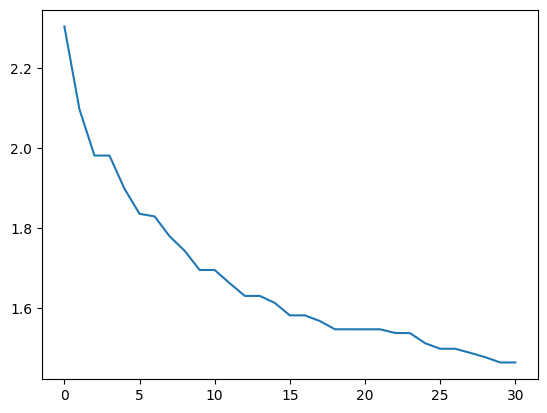

In [ ]:
plt.plot([v for _, v in history.losses_centralized])

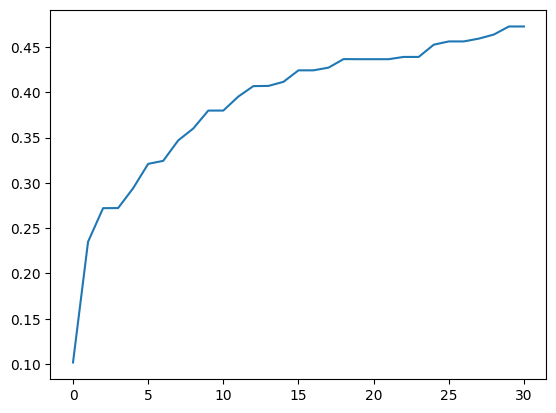

In [ ]:
plt.plot([v for _, v in history.metrics_centralized["accuracy"]])